In [1]:
"""
Eric Born
stock logistic regression
Create a KNN model based upon the mean and standard
deviation measures of the weekly stock returns
"""

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score
from sklearn.model_selection import train_test_split

# setup input directory and filename
ticker = 'BSX-labeled'
input_dir = r'C:\Users\TomBrody\Desktop\Projects\stock-prediction\data'
ticker_file = os.path.join(input_dir, ticker + '.csv')

# read csv file into dataframe
try:
    df = pd.read_csv(ticker_file)
    print('opened file for ticker: ', ticker,'\n')

except Exception as e:
    print(e)
    print('failed to read stock data for ticker: ', ticker)

opened file for ticker:  BSX-labeled 



In [2]:
# Create class column where red = 0 and green = 1
df['class'] = df['label'].apply(lambda x: 1 if x =='green' else 0)

# Create separate dataframes for 2017 and 2018 data
# 2017 will be used as training, 2018 as testing for the model
df_2017 = df.loc[df['td_year']==2017]
df_2018 = df.loc[df['td_year']==2018]

# Reset indexes
df_2017 = df_2017.reset_index(level=0, drop=True)
df_2018 = df_2018.reset_index(level=0, drop=True)

# Create reduced dataframe only containing week number, mu, sig and label
df_2017_reduced = pd.DataFrame( {'week nbr' : range(1, 53),
                'mu'    : df_2017.groupby('td_week_number')['return'].mean(),
                'sig'   : df_2017.groupby('td_week_number')['return'].std(),
                'label' : df_2017.groupby('td_week_number')['class'].first()})

# Create reduced dataframe only containing week number, mu, sig and label
df_2018_reduced = pd.DataFrame( {'week nbr' : range(0, 53),
                'mu'    : df_2018.groupby('td_week_number')['return'].mean(),
                'sig'   : df_2018.groupby('td_week_number')['return'].std(),
                'label' : df_2018.groupby('td_week_number')['class'].first()})

# Replacing nan in week 52 sigma column with a zero due to 
# there being only 1 trading day that week.
df_2018_reduced = df_2018_reduced.fillna(0)

# remove index name labels from dataframes
del df_2017_reduced.index.name
del df_2018_reduced.index.name

In [3]:
# Define features labels
features = ['mu', 'sig']

# create x dataset from 2017 features values
X = df_2017_reduced[features].values

# create y datasets from 2017 label values
Y = df_2017_reduced['label'].values

# Setup scalers X dataset
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# divide X and Y into test/train 50/50
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5, 
                                                    random_state = 3)
# Create empty lists to store the models error rate and 
# accuracy across various K's
error_rate = []
accuracy = []
k_value = []

In [4]:
# For loop to test the model using 2017 data
# with k neighbors set to 3, 5, 7, 9 and 11
try:
    for k in range (3, 13, 2):
        # Create the classifier with neighbors set to k from the loop
        knn_classifier = KNeighborsClassifier(n_neighbors = k)
       
        # Train the classifier
        knn_classifier.fit(X_train, Y_train)
        
        # Perform predictions
        pred_k = knn_classifier.predict(X_test)
        
        # Store error rate and accuracy for particular K value
        k_value.append(k)
        error_rate.append(round(np.mean(pred_k != Y_test) * 100, 2))
        accuracy.append(round(sum(pred_k == Y_test) / len(pred_k) * 100, 2))
except Exception as e:
    print(e)
    print('failed to build the KNN classifier.')

In [5]:
for i in range (0,5):
    print('The accuracy on 2017 data when K =', k_value[i], 'is:', accuracy[i])

The accuracy on 2017 data when K = 3 is: 73.08
The accuracy on 2017 data when K = 5 is: 73.08
The accuracy on 2017 data when K = 7 is: 73.08
The accuracy on 2017 data when K = 9 is: 69.23
The accuracy on 2017 data when K = 11 is: 61.54


Text(0, 0.5, 'Accuracy')

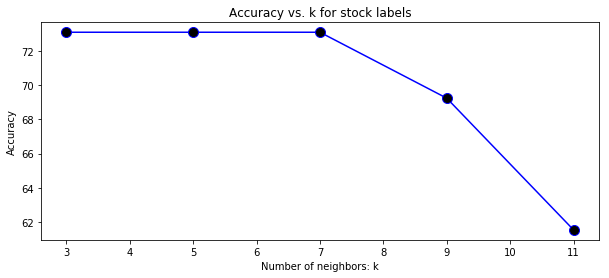

In [6]:
# create a plot to display the accuracy of the model across K
fig = plt.figure(figsize=(10, 4))
ax = plt.gca()
plt.plot(range(3, 13, 2), accuracy, color ='blue',
         marker = 'o', markerfacecolor = 'black', markersize = 10)
plt.title('Accuracy vs. k for stock labels')
plt.xlabel('Number of neighbors: k')
plt.ylabel('Accuracy')

In [7]:
# setup and test on 2018 data with k = 5
# Create x test set for 2018
x_test = df_2018_reduced[features].values
y_2018_test = df_2018_reduced['label'].values

# scaler for 2018 test data
scaler.fit(x_test)
x_2018_test = scaler.transform(x_test)

# Create the classifier with neighbors set to 5
knn_2018 = KNeighborsClassifier(n_neighbors = 5)

# Train the classifier using all of 2017 data
knn_2018.fit(X, Y)
        
# Perform predictions on 2018 data
pred_2018 = knn_2018.predict(x_2018_test)

# Capture error and accuracy rates for 2018 predictions
error_2018 = round(np.mean(pred_2018 != y_2018_test) * 100, 2)
accuracy_2018 = round(sum(pred_2018 == y_2018_test) / len(pred_2018) * 100, 2)

# accuracy is 83.13%
print('\nThe accuracy on 2018 data when K = 5 is:', accuracy_2018, '%')


The accuracy on 2018 data when K = 5 is: 81.13 %


In [8]:
# Output the confusion matrix
cm = confusion_matrix(y_2018_test, pred_2018)
print('\nConfusion matrix for year 2 predictions:')
print(cm, '\n')


Confusion matrix for year 2 predictions:
[[20  9]
 [ 1 23]] 



The specificity is: 20/29 = 0.69 = 69%
The recall is: 23/24 = 95.83 %


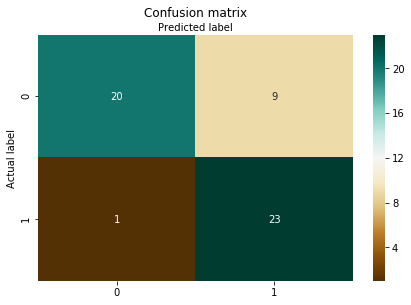

In [9]:
# Create confusion matrix heatmap
# setup class names and tick marks
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap and labels
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="BrBG", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# what is true positive rate (sensitivity or recall) and true
# negative rate (specificity) for year 2?
print('The specificity is: 20/29 = 0.69 = 69%')	
print('The recall is: 23/24 =', 
      round(recall_score(y_2018_test, pred_2018) * 100, 2),'%')

In [10]:
# Implemented trading strategy based upon label predicitons vs
# buy and hold strategy

# Initialize wallet and shares to track current money and number of shares.
wallet = 100.00
shares = 0
worth = 0

# stores adj_close values for the last day of each trading week
adj_close = df_2018.groupby('td_week_number')['adj_close'].last()

# stores open price for the first day of each trading week
open_price = df_2018.groupby('td_week_number')['open'].first()

In [11]:
# for loop that evaluates the dataset deciding when to buy/sell based
# upon the prediction labels. 0 is a bad week, 1 is a good week
try:
    for i in range(0, len(pred_2018)):
        # Sell should occur on the last day of a green week at 
        # the adjusted_close price. Since i is tracking the current
        # trading week we need to minus 1 to get the adjusted close price
        # from the previous trading week
        if pred_2018[i] == 0 and shares > 0:
            wallet = round(shares * adj_close[i - 1], 2)
            shares = 0
            
        # Buy should occur on the first day of a green week at the open price
        if pred_2018[i] == 1 and shares == 0: 
            shares = wallet / open_price[i]
            wallet = 0            
            
except Exception as e:
    print(e)
    print('Failed to evaluate df_2018 labels')

In [12]:
# set worth by multiplying stock price on final day by total shares
worth = round(shares * adj_close[52], 2)

if worth == 0:
    worth = wallet
    profit = round(wallet - 100.00, 2)
else:
    profit = round(worth - 100.00, 2)

# Total Cash: $0
# Total shares: 6.703067 
# Worth: $236.89
# This method would close the year at $ 141.7 a profit of $ 41.7
print('\n2018 Label Strategy:')
print('Total Cash: $', wallet, '\nTotal shares:', round(shares, 6),
      '\nWorth: $', worth)    
print('This method would close the year at $', worth, 'a profit of $', profit)


2018 Label Strategy:
Total Cash: $ 0 
Total shares: 6.769632 
Worth: $ 239.24
This method would close the year at $ 239.24 a profit of $ 139.24


In [13]:
# Buy and hold
# Initialize wallet and shares to track current money and number of shares.
wallet = 100.00
shares = 0
profit = 0
worth = 0

# Calculate shares, worth and profit
shares = round(wallet / float(open_price[0]), 6)
worth = round(shares * adj_close[52], 2)
profit = round(worth - 100.00, 2)

#Currently own 4.009623 shares 
#Worth $ 141.70
#Selling on the final day would result in $ 141.7 a profit of $ 41.7
print('\n2018 buy and hold:','\nCurrently own', shares, 'shares',
      '\nWorth','$',"%.2f"%round(worth, 2))
print('Selling on the final day would result in $',"%.2f"%worth, 
      'a profit of $', "%.2f"%profit)


2018 buy and hold: 
Currently own 4.009623 shares 
Worth $ 141.70
Selling on the final day would result in $ 141.70 a profit of $ 41.70
